In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style('whitegrid')

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
import pathlib
import plot_export

export_path = pathlib.Path('export', '20_arccos_kernel')
export_path.mkdir(parents=True, exist_ok=True)

In [5]:
import keras_dgp

In [6]:
kernel_one = keras_dgp.kernels.ArcCosine(
    order=1,
    amplitude=tf.constant(.1, dtype=tf.float64),
    weights=tf.constant(2., dtype=tf.float64),
    bias=tf.constant(2., dtype=tf.float64),
)

kernel_two = keras_dgp.kernels.ArcCosine(
    order=2,
    amplitude=tf.constant(.1, dtype=tf.float64),
    weights=tf.constant(1., dtype=tf.float64),
    bias=tf.constant(1., dtype=tf.float64),
)

def gp_dist(X, kernel):
    cov = kernel.matrix(X, X)
    cov = cov + tf.eye(cov.shape[0], dtype=tf.float64) * 1e-5
    return tfp.distributions.MultivariateNormalFullCovariance(
        tf.zeros_like(X)[..., 0], cov
    )

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


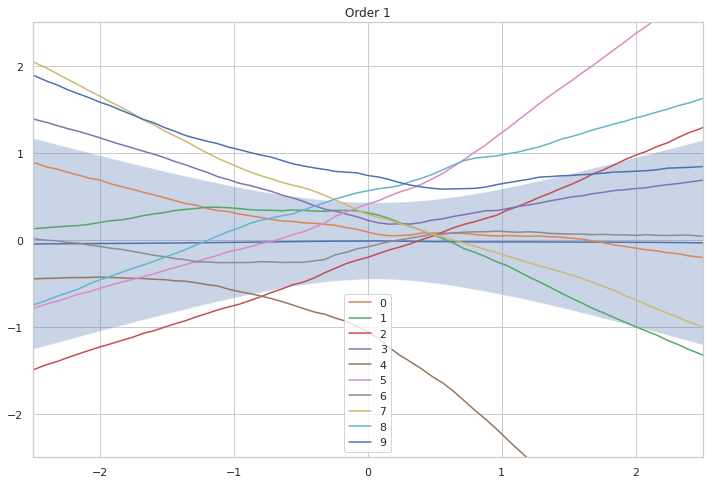

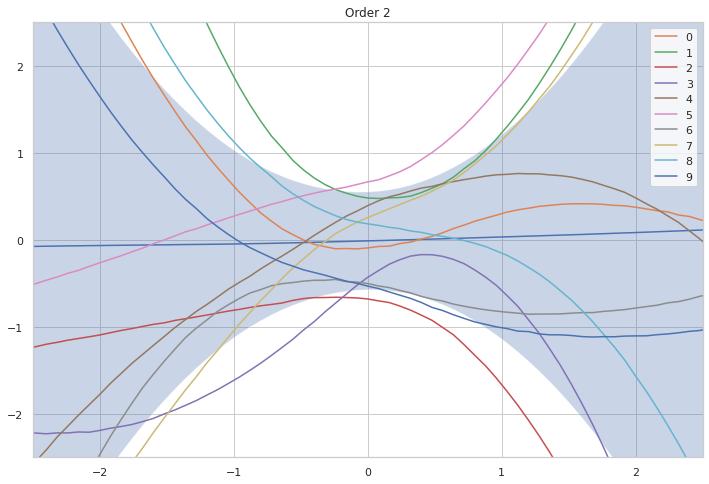

In [7]:
X = np.mgrid[-4:4:101j][..., None]

for kern_ix, kernel in enumerate([kernel_one, kernel_two]):
    prior = gp_dist(X, kernel)
    Ys = prior.sample(500)

    Y_mean = tf.reduce_mean(Ys, axis=0)
    Y_std = tf.math.reduce_std(Ys, axis=0)
    plt.plot(X, Y_mean)
    plt.fill_between(X[..., 0], Y_mean - Y_std, Y_mean + Y_std, alpha=0.3)

    for ix, Y in enumerate(Ys[:10]):
        plt.plot(X, Y, label=f'{ix}')

    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.5, 2.5)
    plt.title(f'Order {kern_ix + 1}')
    plt.legend()
    plt.show()

    plot_export.to_text(
        export_path / f'arc_cos_order_{kern_ix + 1}.dat',
        [X, Y_mean, Y_std, 2 * Y_std, *Ys],
        ['X', 'mean', 'std', '2std', *[f'sample_{ix}' for ix in range(20)]],
    )